In [6]:
import pandas as pd
import numpy as np 

from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from CustomTransformers import *
from Evaluation import *
from ClassifierAnalyzer import *

## 1. Getting the Data

We can either read data from json files previously downloaded from spark machine or get data locally from spark:

### 1.1 Reading From JSON

In [7]:
# read data stored locally 
#train = pd.read_json("../data/training.json")
#test = pd.read_json("../data/test.json")

### 1.2 Getting and Filtering Data With Spark

In [8]:
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import explode, lit, col
from pyspark.sql import functions as F

class API:
    def __init__(self, directory, frac=1, seed=123):
        if frac < 1:
            self.data = spark.read.parquet(directory).sample(False, frac, seed)
        else:
            self.data = spark.read.parquet(directory)
          
    def get_raw_data(self):
         return self.data

    def get_filtered_data(self, terms=[], hashtags=None, users=None, locs=None, mentions=None):   
        terms_regex = '|'.join(terms)
        filtered_data = (labled_data.filter(labled_data['term'].rlike(terms_regex)))

        if hashtags != None:
            hashtags_regex = '|'.join(hashtags)
            filtered_data = filtered_data.union(labled_data.filter(labled_data['hashtag'].rlike(hashtags_regex)))

        if users != None:
            users_regex = '|'.join(users)
            filtered_data = filtered_data.union(labled_data.filter(labled_data['from_user'].rlike(users_regex)))

        if locs != None:
            locs_regex = '|'.join(locs)
            filtered_data = filtered_data.union(labled_data.filter(labled_data['location'].rlike(locs_regex)))

        if mentions != None:
            mentions_regex = '|'.join(mentions)
            filtered_data = filtered_data.union(labled_data.filter(labled_data['mention'].rlike(mentions_regex)))

        return filtered_data.dropDuplicates().cache()

In [9]:
from pyspark.sql.functions import explode, lit, col

from hashtag_dict import topic_dict

class DataPreprocessor():
    def __init__(self, data):
        self.data = data
        self.labled_data = None

        tokenizer = Tokenizer(inputCol="hashtag", outputCol="each_hashtag")
        hashtags_df = tokenizer.transform(self.data)

        hashtag = hashtags_df.select("tweet_id","create_time","each_hashtag")
        self.hash_exploded = hashtag.withColumn('each_hashtag', explode('each_hashtag'))
    
    def get_labled_data(self, topic):
        if self.labled_data == None:
            topic_lables = topic_dict[topic]

            topical_ids = self.hash_exploded.select(self.hash_exploded.tweet_id)\
                                                    .where(self.hash_exploded.each_hashtag\
                                                            .isin(topic_lables))\
                                                    .distinct().cache()

            labled_topical = topical_ids.withColumn("topical", lit(1))
            self.labled_data = self.data.join(labled_topical, self.data.tweet_id == labled_topical.tweet_id, "left")\
                                                      .select(self.data.create_time,\
                                                             self.data.from_id,\
                                                             self.data.from_user,\
                                                             self.data.hashtag,\
                                                             self.data.location,\
                                                             self.data.mention,\
                                                             self.data.tweet_id,\
                                                             self.data.term,\
                                                              F.when(labled_topical.topical == 1, 1.0)\
                                                                .otherwise(0.0).alias("label")).distinct().cache()
        return self.labled_data
    
    def get_num_of_positvies(self):
        if self.labled_data == None:
            return 0
        
        return self.labled_data.where(col("label") == 1.0).count()
    
    def get_data_size(self):
        if self.labled_data == None:
            return 0
        
        return self.labled_data.count()
        
    def temporal_split(self, topic, balance_data=True, seed=0):
        topic_lables = topic_dict[topic]
        labled_data = self.get_labled_data(topic)
        tweet_labels = labled_data.select("tweet_id", "label")
        
        df_birthday = self.hash_exploded.join(tweet_labels,\
                                 self.hash_exploded.tweet_id == tweet_labels.tweet_id,\
                                 "inner").select(self.hash_exploded.create_time,\
                                                 self.hash_exploded.each_hashtag,\
                                                 self.hash_exploded.tweet_id)
        
        ## Find out the "birthday", or the earliest appearing time of each hashtag. 
        ## (add an extra column of 1 to mark as topical, will be used in a join later)
        ordered_hashtag_set = df_birthday.\
                              groupby("each_hashtag").\
                              agg({"create_time": "min"}).\
                              orderBy('min(create_time)', ascending=True).\
                              withColumnRenamed("min(create_time)", "birthday").\
                              where(df_birthday.each_hashtag.isin(topic_lables)).cache()
                            
        time_span = ordered_hashtag_set.count()

        train_test_split_time = np.floor(np.multiply(time_span, 0.85)).astype(int)

        # Converting to Pandas for random row access.
        pd_ordered_hashtag_set = ordered_hashtag_set.toPandas()

        # locate the timestamp of the cutoff point. Will be used later to split Dataframe.
        train_test_time = pd_ordered_hashtag_set.iloc[train_test_split_time]['birthday']
    
        training_set = labled_data.where(col("create_time") <= train_test_time)
        test_set = labled_data.where(col("create_time") > train_test_time)
        
        if balance_data == True:
            training_set = training_set.sampleBy("label", fractions={0.0: 0.001, 1.0: 1}, seed=seed) 
        
        return training_set, test_set

In [10]:
directory = "/mnt/66e695cd-1a0c-4e3b-9a50-55e01b788529/Training_data/Staging_final/"
api = API(directory, frac=0.01, seed=123)
raw_data = api.get_raw_data()

#### 1.2.1 Labeling

In [11]:
dp = DataPreprocessor(raw_data)
train, test = dp.temporal_split("Natr_Disaster")

In [12]:
train = train.toPandas()
test = test.toPandas()

In [13]:
train_features = train.drop('label', axis=1)
train_target = train['label']

test_features = test.drop('label', axis=1)
test_target = test['label']

## 2. Train the initial classifier

Set up a pipeline for training a classifier based on the training data. Vectorize each of the five main feature columns (Term, Hashtag, From_id, Location, Mention) and create a single feature vector with FeatureUnion.
The classifier is a Logistic Regression with Cross validation which currently is set up under the default configuration.  
We will use the parameters of this classifier for selecting features in the next stage.

In [14]:
pipeline = Pipeline([
    ('features', FeatureUnion(
            transformer_list=[
                ('term', Pipeline([
                    ('selector', ItemSelector(key='term')),
                    ('tfidf', TfidfVectorizer(stop_words='english')),
                ])),
                
                ('hashtag', Pipeline([
                    ('selector', ItemSelector(key='hashtag')),
                    ('count', CountVectorizer()),
                ])),
                
                ('user', Pipeline([
                    ('selector', ItemSelector(key='from_user')),
                    ('count', CountVectorizer()),
                ])),
                
                ('location', Pipeline([
                    ('selector', ItemSelector(key='location')),
                    ('count', CountVectorizer()),
                ])),
                
                ('mention', Pipeline([
                    ('selector', ItemSelector(key='mention')),
                    ('count', CountVectorizer()),
                ]))
               
            ])),
    
    ('classifier', LogisticRegressionCV())  
])

In [15]:
pipeline.fit(train_features, train_target)

predictions = pipeline.predict_proba(test_features)[:, 1]

In [16]:
print_evaluation_summary(test_target, predictions, 100)

Precision@100 = 0.988505747126 
Recall@100 = 0.934782608696
AveP = 0.727947432115


In [18]:
pipeline2 = Pipeline([
    ('features', FeatureUnion(
            transformer_list=[
                ('term', Pipeline([
                    ('selector', ItemSelector(key='term')),
                    ('tfidf', TfidfVectorizer(stop_words='english')),
                ])),
                
                ('hashtag', Pipeline([
                    ('selector', ItemSelector(key='hashtag')),
                    ('count', HashtagCountVectorizer()),
                ])),
            ])),
    
    ('classifier', LogisticRegressionCV())    
])

In [19]:
pipeline2.fit(train_features, train_target)

predictions2 = pipeline2.predict_proba(test_features)[:, 1]

In [20]:
print_evaluation_summary(test_target, predictions2, 100)

Precision@100 = 1.0 
Recall@100 = 1.0
AveP = 0.889932393727


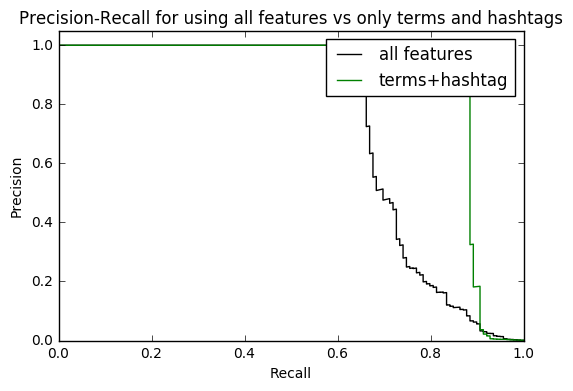

In [21]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(test_target, predictions)
precision2, recall2, _ = precision_recall_curve(test_target, predictions2)

pr1 = plt.plot(recall, precision, color='black', label="all features")
pr2 = plt.plot(recall2, precision2, color='g', label="terms+hashtag")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall for using all features vs only terms and hashtags')
plt.show()

Logistic regression performance comparision by using all feature groups vs terms and hashtags
(Unrelated to current problem: using terms + hashtags yields better results. Due to no features selection/small data size?)

## 3. Test TopK feature selection performance

In [22]:
labled_data = dp.get_labled_data("Natr_Disaster")
analyzer = ClassifierAnalyzer(pipeline)

In [23]:
analyzer.print_top_features()

Top Terms: u'hurricane', u'yrs', u'help', u'philippines', u'storm', u'eso', u'typhoon', u'safe', u'water', u'victims', u'weather', u'coast', u'sure', u'risk', u'place', u'hit', u'damage', u'took', u'continue', u'aisles'

Top Hashtags: u'prayforthephilippines', u'earthquake', u'storm', u'tornado', u'ukstorm', u'haiyan', u'flood', u'sandy', u'hurricane', u'drought', u'arthur', u'hurricanes', u'eqnz', u'quake', u'typhoon', u'serbiafloods', u'napaquake', u'earthquakeph', u'prayforchile', u'phailin'

Top Users: u'rlawler3', u'shiftlessstevie', u'thefoxnation01', u'asifktkaziz', u'strangeaxle', u'davidgumpher', u'earthquaketime1', u'jilllaner', u'wfhcbandon', u'lawbharath', u'jrcommdoc', u'905shinefm', u'nice_1005', u'what_tha_what', u'suffolkdan86', u'marnielevy', u'ilovehim_o21', u'psychkiddo', u'butterflyblues4', u'millermarias'

Top Locations: u'loc_los_angeles_ca', u'loc_schuylkill_county_pa', u'loc_abu_dhabi_uae', u'loc_bandon_co_cork', u'loc_princeton', u'loc_red_deer_ab', u'loc_chenn

In [39]:
class TestFramework:
    def __init__(self, api, analyzer, configurations=[]):
        self.api = api
        self.analyzer = analyzer
        self.configurations = configurations

    def get_data(self, k, topic):
        top_terms, top_hashtags, top_users, top_locs, top_mentions = self.analyzer.get_top_features(k)

        data = self.api.get_filtered_data(top_terms, top_hashtags, top_users, top_locs, top_mentions)
        dp = DataPreprocessor(data)
        filtered_data = dp.get_labled_data(topic)
        data_size = dp.get_data_size()
        data_positive_count = dp.get_num_of_positvies()
        
        train, test = dp.temporal_split(topic)
        
        return data_positive_count, data_size, train.toPandas(), test.toPandas()
        
    def run_configs(self, topic="Natr_Disaster"):
        pipelines = []
        positive_counts = []
        total_counts = []
       
        for config in self.configurations:
            pipeline = Pipeline([
            ('features', FeatureUnion(
                    transformer_list=[
                        ('term', Pipeline([
                            ('selector', ItemSelector(key='term')),
                            ('tfidf', TfidfVectorizer(stop_words='english')),
                        ])),

                        ('hashtag', Pipeline([
                            ('selector', ItemSelector(key='hashtag')),
                            ('count', CountVectorizer()),
                        ])),

                        ('user', Pipeline([
                            ('selector', ItemSelector(key='from_user')),
                            ('count', CountVectorizer()),
                        ])),

                        ('location', Pipeline([
                            ('selector', ItemSelector(key='location')),
                            ('count', CountVectorizer()),
                        ])),

                        ('mention', Pipeline([
                            ('selector', ItemSelector(key='mention')),
                            ('count', CountVectorizer()),
                        ]))

                    ])),

            ('classifier', LogisticRegressionCV())  
        ])   
            pos, total, train, test = self.get_data(config, topic)
            positive_counts.append(pos)     
            total_counts.append(total)
            
            train_features = train.drop('label', axis=1)
            train_target = train['label']

            test_features = test.drop('label', axis=1)
            test_target = test['label']
            
            pipeline.fit(train_features, train_target)
            pipelines.append(pipeline)
            
        return positive_counts, total_counts, pipelines

In [40]:
configs = [[20, 20, 20, 20, 20], [50, 50, 50, 50, 50], [100, 100, 100, 100, 100], [200, 200, 200, 200, 200]]
tf = TestFramework(api, analyzer, configs)

In [42]:
positives, totals, pipelines = tf.run_configs()

### 3.1 Baseline Evaluation

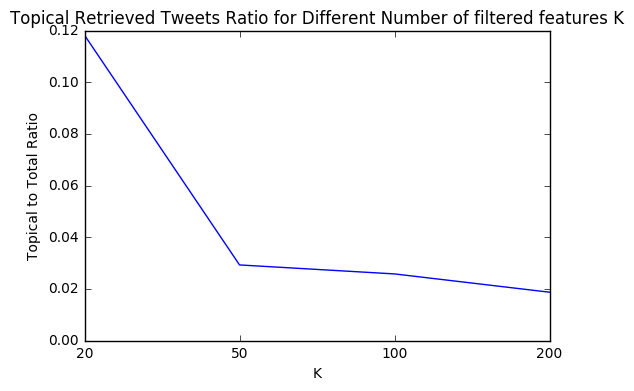

In [50]:
#positives_scaled = [p * 100 for p in positives]
pos_ratio = []
for i in range(0, len(positives_scaled)):
    pos_ratio.append(float(positives_scaled[i]) / totals[i])

N = len(positives)

plt.plot(pos_ratio)

# add some text for labels, title and axes ticks
plt.title("Topical Retrieved Tweets Ratio for Different Number of filtered features K")
plt.ylabel('Topical to Total Ratio')
plt.xlabel('K')
plt.xticks(np.arange(N), ('20', '50', '100', '200'))

plt.show()

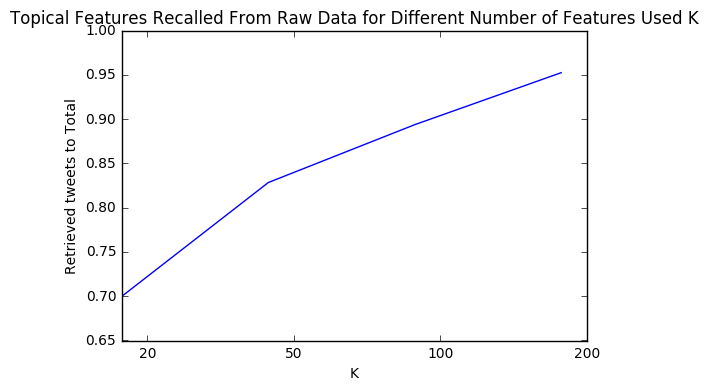

In [52]:
total_pos_count = dp.get_num_of_positvies()
pos_recall = [float(p) / total_pos_count for p in positives]

fig, ax = plt.subplots()
ax.plot(pos_recall)
# add some text for labels, title and axes ticks
ax.set_ylabel('Retrieved tweets to Total')
ax.set_xlabel('K')
ax.set_title('Topical Features Recalled From Raw Data for Different Number of Features Used K')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('20', '50', '100', '200'))

plt.show()

In [53]:
aveps = []
prec_recall = []
for p in pipelines:
    predictions = p.predict_proba(test_features)[:, 1]
    aveps.append(average_precision_score(test_target, predictions))
    
    precision, recall, _ = precision_recall_curve(test_target, predictions)
    prec_recall.append([precision, recall])

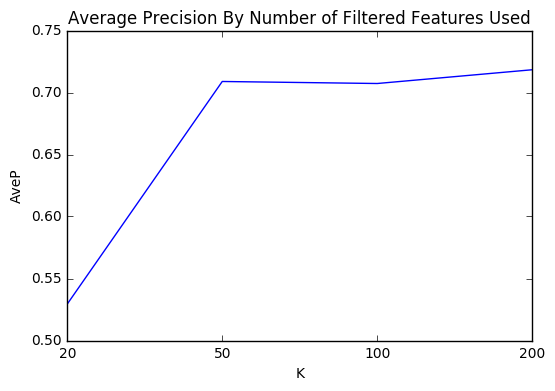

In [55]:
plt.subplot()
plt.plot(aveps)
# add some text for labels, title and axes ticks
plt.ylabel('AveP')
plt.xlabel('K')
plt.title('Average Precision By Number of Filtered Features Used K')
plt.xticks(np.arange(N), ('20', '50', '100', '200'))
plt.show()

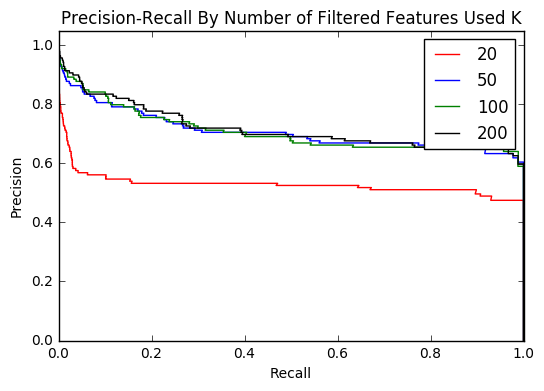

In [56]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

colors = ['r', 'b', 'g', 'k', 'm']
k = [20, 50, 100, 200]
for i in range(0, len(prec_recall)):
    plt.plot(prec_recall[i][0], prec_recall[i][1], color=colors[i], label=k[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall By Number of Filtered Features Used K')
plt.show()